In [2]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

In [73]:
from dataset import DataSet

## config


In [30]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 100

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# try 3 styles
classes = ['northern-renaissance', 'realism', 'abstract-art']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

checkpoint_dir = "models/"

In [31]:
X_tr = np.loadtxt("../data/features_cnn/X_tr.txt")
X_te = np.loadtxt("../data/features_cnn/X_te.txt")

y_tr = np.loadtxt("../data/features_cnn/Y_tr.txt", dtype=int)
y_te = np.loadtxt("../data/features_cnn/Y_te.txt", dtype=int)

In [32]:
X_tr = X_tr[(y_tr==4) | (y_tr==5) | (y_tr==6)]
y_tr = y_tr[(y_tr==4) | (y_tr==5) | (y_tr==6)]
X_te = X_te[(y_te==4) | (y_te==5) | (y_te==6)]
y_te = y_te[(y_te==4) | (y_te==5) | (y_te==6)]

y_tr[(y_tr==4)] = 0
y_tr[(y_tr==5)] = 1
y_tr[(y_tr==6)] = 2

y_te[(y_te==4)] = 0
y_te[(y_te==5)] = 1
y_te[(y_te==6)] = 2

In [37]:
print(X_tr.shape)
print(y_tr.shape)

tr_num = X_tr.shape[0]
va_idx_end = int(validation_size*tr_num)
X_va = X_tr[:va_idx_end]
y_va = y_tr[:va_idx_end]

X_tr = X_tr[va_idx_end:]
y_tr = y_tr[va_idx_end:]

print(X_va.shape)
print(y_va.shape)

print(y_tr[(y_tr==0)].shape)
print(y_tr[(y_tr==1)].shape)
print(y_tr[(y_tr==2)].shape)

print(y_va[(y_va==0)].shape)
print(y_va[(y_va==1)].shape)
print(y_va[(y_va==2)].shape)



(3005, 30000)
(3005,)
(480, 30000)
(480,)
(813,)
(864,)
(848,)
(168,)
(152,)
(160,)


In [38]:
print(X_te.shape)
print(y_te.shape)
print(y_te[(y_te==0)].shape)
print(y_te[(y_te==1)].shape)
print(y_te[(y_te==2)].shape)

(338, 30000)
(338,)
(117,)
(120,)
(101,)


In [16]:
def get_arr(y):
    y_arr = np.zeros((y.shape[0], num_classes))
    for i in range(y.shape[0]):
        val = y[i]
        arr = np.zeros((num_classes))
        arr[val] = 1
        y_arr[i,:] = arr
    return y_arr



In [39]:
y_tr_arr = get_arr(y_tr)
y_va_arr = get_arr(y_va)
y_te_arr = get_arr(y_te)

In [40]:
print(y_tr_arr.shape)

(2525, 3)


In [77]:
print(X_tr.shape)

(2525, 30000)


In [75]:
data_train = DataSet(X_tr, y_tr_arr, y_tr, classes)

In [80]:
print(data_train.images.shape)
print(data_train.labels.shape)
print(data_train.cls.shape)
print(data_train.cls[0])
print(data_train.label_texts.shape)
print(data_train.label_texts[0])

(2525, 30000)
(2525, 3)
(2525,)
2
(2525,)
abstract-art


In [81]:
data_valid = DataSet(X_va, y_va_arr, y_va, classes)

In [82]:
print(data_valid.images.shape)
print(data_valid.labels.shape)
print(data_valid.cls.shape)
print(data_valid.cls[0])
print(data_valid.label_texts.shape)
print(data_valid.label_texts[0])

(480, 30000)
(480, 3)
(480,)
0
(480,)
northern-renaissance


In [123]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is None:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0} \n Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

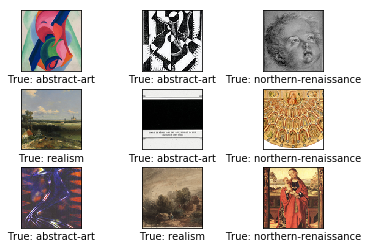

In [124]:
plot_images(images=data_valid.images, cls_true=data_valid.label_texts)

In [24]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [25]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [26]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    keep_prob = 0.5
    layer = tf.nn.dropout(layer, keep_prob)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [27]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [28]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [29]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [42]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [43]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [45]:
y_true_cls = tf.argmax(y_true, axis=1)

## Convolutional Layers

In [46]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [47]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 50, 50, 32) dtype=float32>

In [48]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [49]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 25, 25, 32) dtype=float32>

In [50]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [51]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 13, 13, 64) dtype=float32>

## Flatten Layer

In [52]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [53]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 10816) dtype=float32>

In [54]:
num_features

10816

## Fully-Connected Layer

In [55]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [56]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [57]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [58]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 3) dtype=float32>

## Predicted Class


In [59]:
y_pred = tf.nn.softmax(layer_fc2)

In [60]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost-function to be optimized

In [62]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)

In [63]:
cost = tf.reduce_mean(cross_entropy)

## Optimization Method

In [64]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance Measures

In [65]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [66]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [67]:
session = tf.Session()

In [69]:
session.run(tf.global_variables_initializer())

In [70]:
train_batch_size = batch_size

In [84]:
def print_progress(epoch, acc, val_acc, val_loss):
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [89]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    acc_tr_sum = 0
    acc_va_sum = 0
    loss_va_sum = 0
    num_sum = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, cls_batch = data_train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, valid_cls_batch = data_valid.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        acc_tr_sum += session.run(accuracy, feed_dict=feed_dict_train)
        acc_va_sum += session.run(accuracy, feed_dict=feed_dict_validate)
        loss_va_sum += session.run(cost, feed_dict=feed_dict_validate)
        num_sum += 1
        
        
        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data_train.num_examples/batch_size) == 0: 
            epoch = int(i / int(data_train.num_examples/batch_size))            
            print_progress(epoch, acc_tr_sum / num_sum, acc_va_sum / num_sum, loss_va_sum / num_sum)
            acc_tr_sum = 0
            acc_va_sum = 0
            loss_va_sum = 0
            num_sum = 0

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-function to plot example errors

In [119]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data_valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    print(cls_pred.shape)
    print(cls_pred)
#     cls_pred = np.array([classes[i] for i in cls_pred[incorrect]])

    # Get the true classes for those images.
    cls_true = data_valid.label_texts[incorrect]
    print(cls_true.shape)
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [120]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    
#     cls_pred = np.array([classes[i] for i in cls_pred])

    # Get the true classifications for the test-set.
    cls_true = data_valid.label_texts
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Helper-function for showing the performance

In [121]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data_valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data_valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data_valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data_valid.label_texts)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [96]:
optimize(num_iterations=1)


Epoch 1 --- Training Accuracy:  40.6%, Validation Accuracy:  31.2%, Validation Loss: 1.099
Time elapsed: 0:00:02


Accuracy on Test-Set: 33.5% (161 / 480)
Example errors:


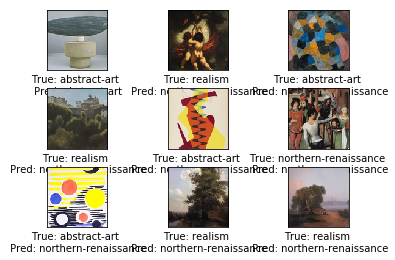

Confusion Matrix:
[[ 44 116   0]
 [ 51 117   0]
 [ 37 115   0]]


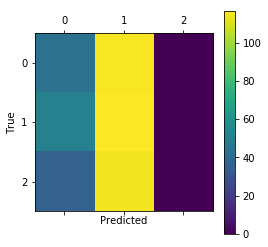

In [100]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [102]:
dada = data_valid.cls
print(dada[(dada==0)].shape)
print(dada[(dada==1)].shape)
print(dada[(dada==2)].shape)

(168,)
(152,)
(160,)


## More iterations

In [103]:
optimize(num_iterations=100)

Epoch 2 --- Training Accuracy:  40.0%, Validation Accuracy:  41.3%, Validation Loss: 1.072
Time elapsed: 0:01:39


Accuracy on Test-Set: 47.7% (229 / 480)
Example errors:


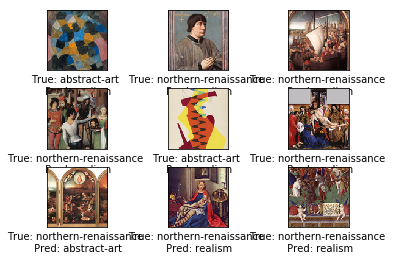

Confusion Matrix:
[[ 92   0  68]
 [ 48   0 120]
 [ 15   0 137]]


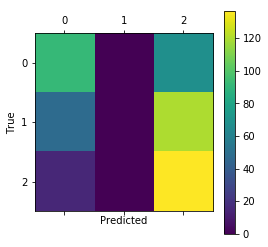

In [104]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [105]:
optimize(num_iterations=1000)

Epoch 3 --- Training Accuracy:  53.1%, Validation Accuracy:  53.6%, Validation Loss: 0.965
Epoch 4 --- Training Accuracy:  56.5%, Validation Accuracy:  54.9%, Validation Loss: 0.910
Epoch 5 --- Training Accuracy:  61.5%, Validation Accuracy:  59.2%, Validation Loss: 0.860
Epoch 6 --- Training Accuracy:  64.5%, Validation Accuracy:  61.8%, Validation Loss: 0.824
Epoch 7 --- Training Accuracy:  68.2%, Validation Accuracy:  64.1%, Validation Loss: 0.795
Epoch 8 --- Training Accuracy:  70.8%, Validation Accuracy:  66.7%, Validation Loss: 0.764
Epoch 9 --- Training Accuracy:  72.4%, Validation Accuracy:  68.3%, Validation Loss: 0.753
Epoch 10 --- Training Accuracy:  73.7%, Validation Accuracy:  68.3%, Validation Loss: 0.735
Epoch 11 --- Training Accuracy:  74.4%, Validation Accuracy:  68.5%, Validation Loss: 0.730
Epoch 12 --- Training Accuracy:  75.2%, Validation Accuracy:  69.6%, Validation Loss: 0.717
Epoch 13 --- Training Accuracy:  76.3%, Validation Accuracy:  70.1%, Validation Loss: 0

Accuracy on Test-Set: 69.0% (331 / 480)
Example errors:
(149,)
(149,)


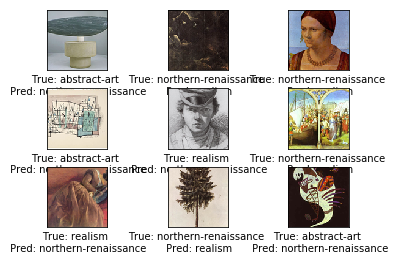

Confusion Matrix:
[[100  55   5]
 [ 21 137  10]
 [ 10  48  94]]


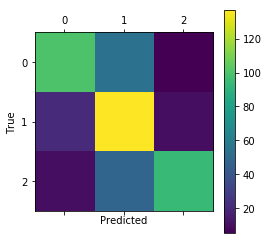

In [127]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [128]:
optimize(num_iterations=10000)

Epoch 16 --- Training Accuracy:  78.7%, Validation Accuracy:  70.9%, Validation Loss: 0.683
Epoch 17 --- Training Accuracy:  79.3%, Validation Accuracy:  71.9%, Validation Loss: 0.688
Epoch 18 --- Training Accuracy:  80.2%, Validation Accuracy:  71.0%, Validation Loss: 0.681
Epoch 19 --- Training Accuracy:  80.3%, Validation Accuracy:  71.3%, Validation Loss: 0.681
Epoch 20 --- Training Accuracy:  80.7%, Validation Accuracy:  71.5%, Validation Loss: 0.680
Epoch 21 --- Training Accuracy:  81.0%, Validation Accuracy:  70.6%, Validation Loss: 0.688
Epoch 22 --- Training Accuracy:  81.6%, Validation Accuracy:  72.0%, Validation Loss: 0.685
Epoch 23 --- Training Accuracy:  82.0%, Validation Accuracy:  71.1%, Validation Loss: 0.680
Epoch 24 --- Training Accuracy:  82.4%, Validation Accuracy:  71.5%, Validation Loss: 0.682
Epoch 25 --- Training Accuracy:  82.8%, Validation Accuracy:  71.7%, Validation Loss: 0.684


KeyboardInterrupt: 

Accuracy on Test-Set: 70.8% (340 / 480)
Example errors:
(140,)
(140,)


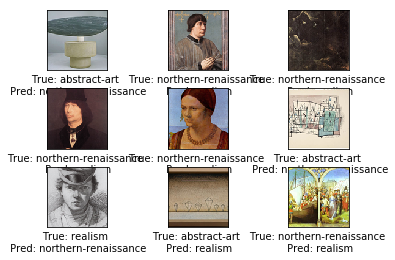

Confusion Matrix:
[[ 93  49  18]
 [ 12 139  17]
 [  6  38 108]]


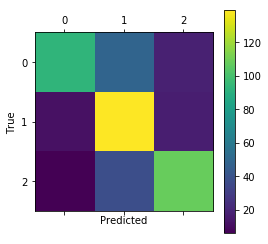

In [129]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)